# Logistic Regression

Ref: Chap 4 of Mar18

https://cfteach.github.io/brds/referencesmd.html

In [1]:
!pip install pymc3 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 12.8 MB/s 
     |████████████████████████████████| 1.8 MB 30.9 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529964 sha256=defebffb659cb5ed16c8f722ef3988e92655cced11359b7b4bebf871f2b9ba9f
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az
import requests
import io 

In [3]:
az.style.use('arviz-darkgrid')

Text(0, 0.5, 'logistic(z)')

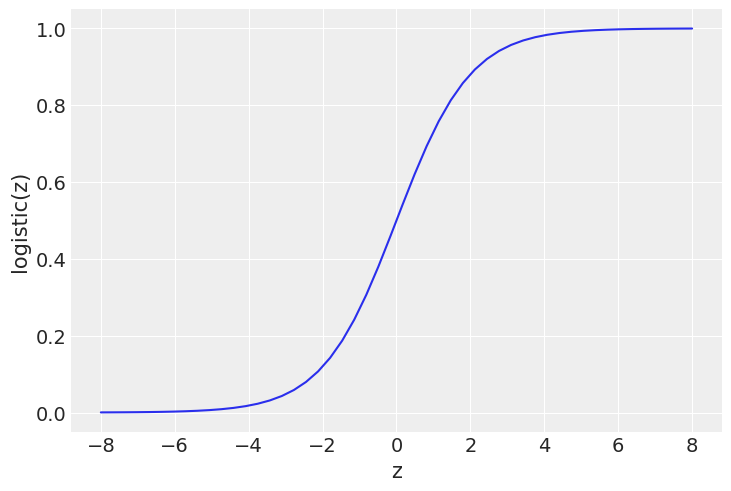

In [4]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')

## The Iris Dataset

In [5]:
target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/iris.csv' 

download = requests.get(target_url).content
iris = pd.read_csv(io.StringIO(download.decode('utf-8')))

iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

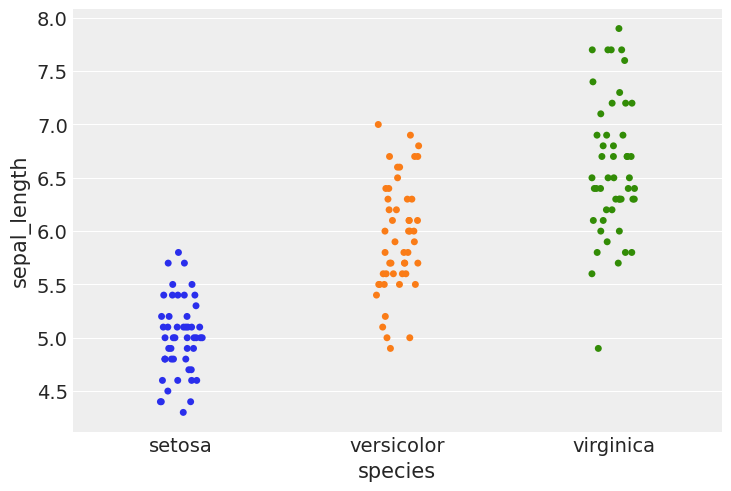

In [6]:
#using stripplot function from seaborn 

sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)



/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self._figure.tight_layout(*args, **kwargs)


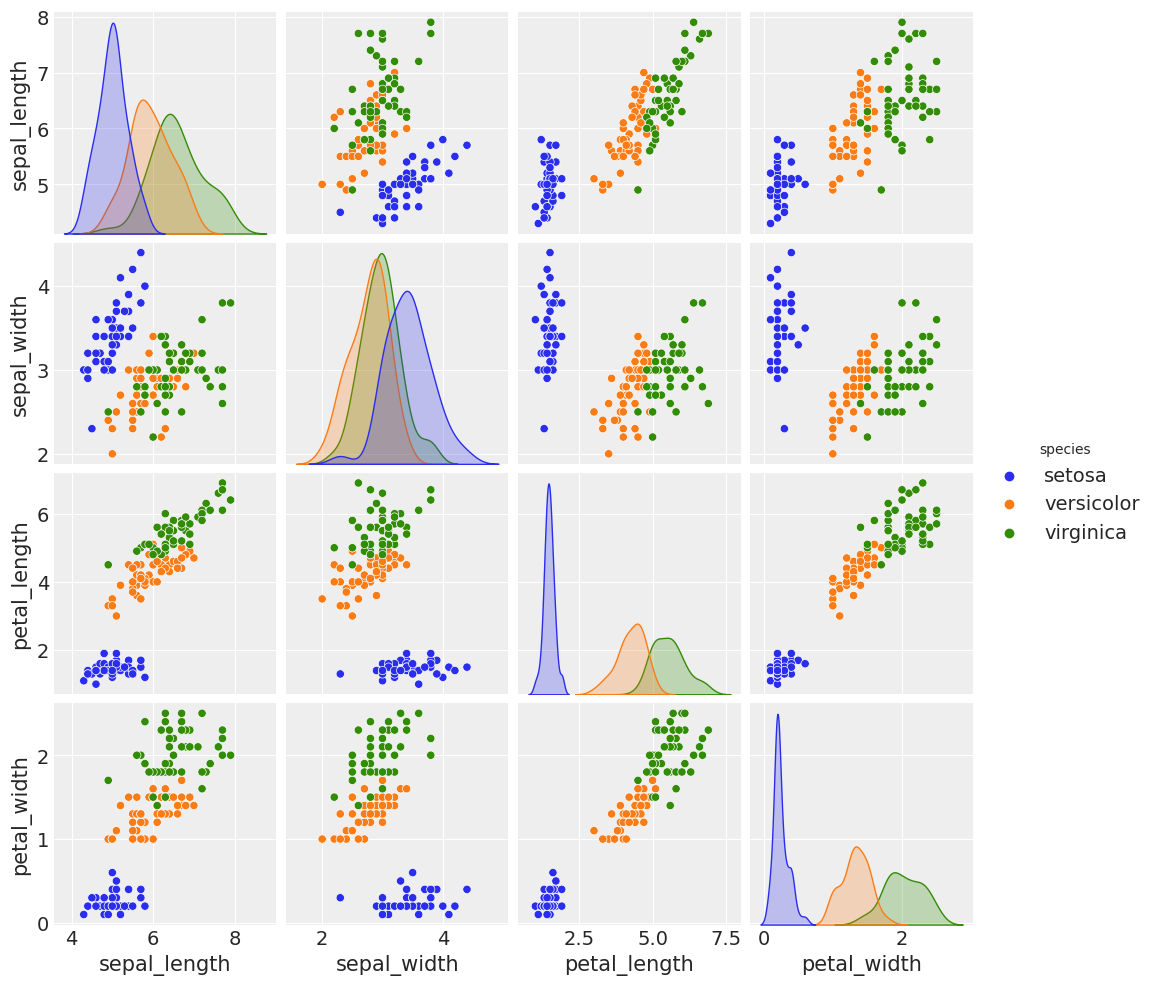

In [7]:
sns.pairplot(iris, hue='species', diag_kind='kde')

### The logistic model applied to the iris dataset 

In [8]:
df = iris.query("species == ('setosa', 'versicolor')")

In [9]:
df

sepal_length  sepal_width  petal_length  petal_width     species
0            5.1          3.5           1.4          0.2      setosa
1            4.9          3.0           1.4          0.2      setosa
2            4.7          3.2           1.3          0.2      setosa
3            4.6          3.1           1.5          0.2      setosa
4            5.0          3.6           1.4          0.2      setosa
..           ...          ...           ...          ...         ...
95           5.7          3.0           4.2          1.2  versicolor
96           5.7          2.9           4.2          1.3  versicolor
97           6.2          2.9           4.3          1.3  versicolor
98           5.1          2.5           3.0          1.1  versicolor
99           5.7          2.8           4.1          1.3  versicolor

[100 rows x 5 columns]

In [10]:
y_0 = pd.Categorical(df['species']).codes

In [11]:
print(y_0, len(y_0))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 100


In [12]:
# let's select one variate
x_n = 'sepal_length'
x_0 = df[x_n].values
#print(x_0)

# let's center our dataset, as we have done in other exercises
x_c = x_0 - x_0.mean()
print(x_c)

[-0.371 -0.571 -0.771 -0.871 -0.471 -0.071 -0.871 -0.471 -1.071 -0.571
 -0.071 -0.671 -0.671 -1.171  0.329  0.229 -0.071 -0.371  0.229 -0.371
 -0.071 -0.371 -0.871 -0.371 -0.671 -0.471 -0.471 -0.271 -0.271 -0.771
 -0.671 -0.071 -0.271  0.029 -0.571 -0.471  0.029 -0.571 -1.071 -0.371
 -0.471 -0.971 -1.071 -0.471 -0.371 -0.671 -0.371 -0.871 -0.171 -0.471
  1.529  0.929  1.429  0.029  1.029  0.229  0.829 -0.571  1.129 -0.271
 -0.471  0.429  0.529  0.629  0.129  1.229  0.129  0.329  0.729  0.129
  0.429  0.629  0.829  0.629  0.929  1.129  1.329  1.229  0.529  0.229
  0.029  0.029  0.329  0.529 -0.071  0.529  1.229  0.829  0.129  0.029
  0.029  0.629  0.329 -0.471  0.129  0.229  0.229  0.729 -0.371  0.229]


In [13]:
with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    trace_0 = pm.sample(2000, tune = 2000, return_inferencedata=True)

In [14]:
varnames = ['α', 'β', 'bd']
res = az.summary(trace_0)
#print(res)
az.summary(trace_0)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α      0.309  0.351  -0.345    0.955      0.006    0.005    2972.0    2475.0   
β      5.409  1.047   3.469    7.348      0.021    0.015    2655.0    2333.0   
θ[0]   0.164  0.060   0.060    0.277      0.001    0.001    3071.0    2506.0   
θ[1]   0.068  0.037   0.011    0.135      0.001    0.000    2948.0    2406.0   
θ[2]   0.027  0.021   0.001    0.064      0.000    0.000    2867.0    2277.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
θ[96]  0.815  0.067   0.689    0.930      0.001    0.001    2727.0    2186.0   
θ[97]  0.980  0.018   0.947    0.999      0.000    0.000    2609.0    2140.0   
θ[98]  0.164  0.060   0.060    0.277      0.001    0.001    3071.0    2506.0   
θ[99]  0.815  0.067   0.689    0.930      0.001    0.001    2727.0    2186.0   
bd    -0.056  0.065  -0.170    0.070      0.001    0.001    3016.0    2591.0   

       r_hat  
α        1.0  
β        1.0  
θ[0]     1.0  
θ[1]     1.0  
θ[2]     1.0  
...      ...  
θ[96]    1.0  
θ[97]    1.0  
θ[98]    1.0  
θ[99]    1.0  
bd       1.0  

[103 rows x 9 columns]

In [15]:
theta_post= trace_0.posterior['θ'] 
print(np.shape(theta_post))

(2, 2000, 100)


([<matplotlib.axis.XTick at 0x7f5280db0250>,
 [Text(0, 0, '4.0'),
  Text(0, 0, '4.5'),
  Text(0, 0, '5.0'),
  Text(0, 0, '5.5'),
  Text(0, 0, '6.0'),
  Text(0, 0, '6.5'),
  Text(0, 0, '7.0'),
  Text(0, 0, '7.5')])

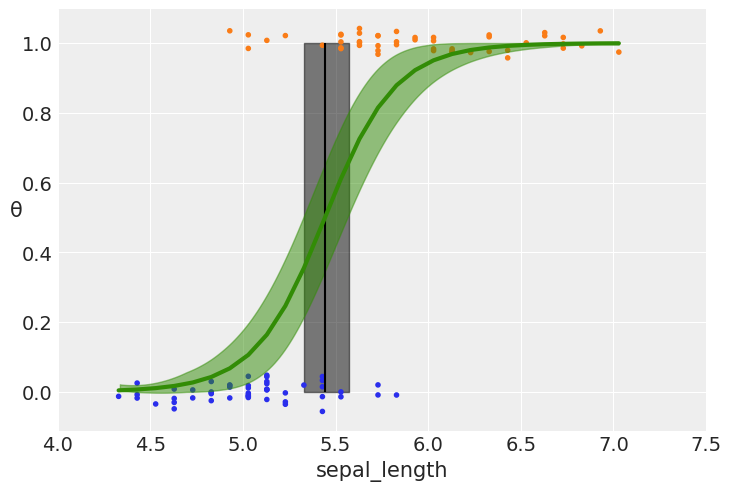

In [16]:
theta = trace_0.posterior['θ'].mean(axis=0).mean(axis=0)
idx = np.argsort(x_c)

np.random.seed(123)


plt.plot(x_c[idx], theta[idx], color='C2', lw=3)

plt.vlines(trace_0.posterior['bd'].mean(), 0, 1, color='k')

bd_hpd = az.hdi(trace_0.posterior['bd'])


plt.fill_betweenx([0, 1], bd_hpd.bd[0].values, bd_hpd.bd[1].values, color='k', alpha=0.5)


plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])


az.plot_hdi(x_c, trace_0.posterior['θ'], color='C2')  #green band 


plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))



## Multiple logistic regression

In [17]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values



In [64]:
print(np.shape(x_1), type(x_1))
t_l = x_1.tolist()
print(np.shape(t_l), type(t_l))


(100, 2) <class 'numpy.ndarray'>
(100, 2) <class 'list'>


In [57]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 

    x__1 = pm.Data('x', x_1)
    y__1 = pm.Data('y', y_1)
     
    μ = α + pm.math.dot(x__1, β)
    
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x__1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y__1) 
 
    trace_1 = pm.sample(2000, tune=4000, return_inferencedata=True, target_accept=0.9)

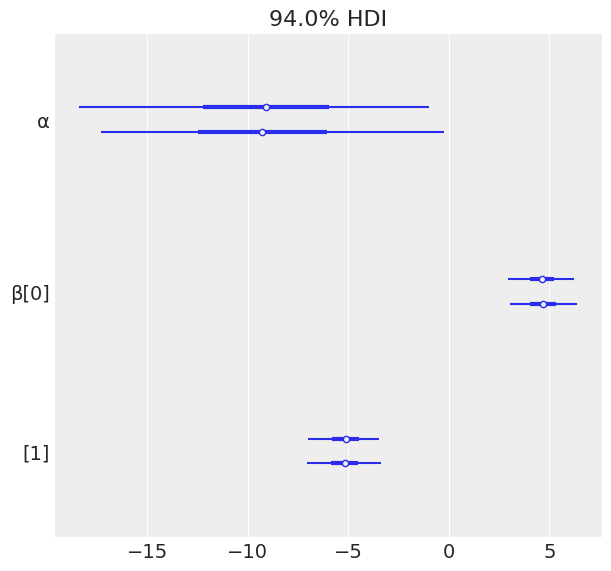

In [58]:
varnames = ['α', 'β'] 
az.plot_forest(trace_1, var_names=varnames);

Text(0, 0.5, 'sepal_width')

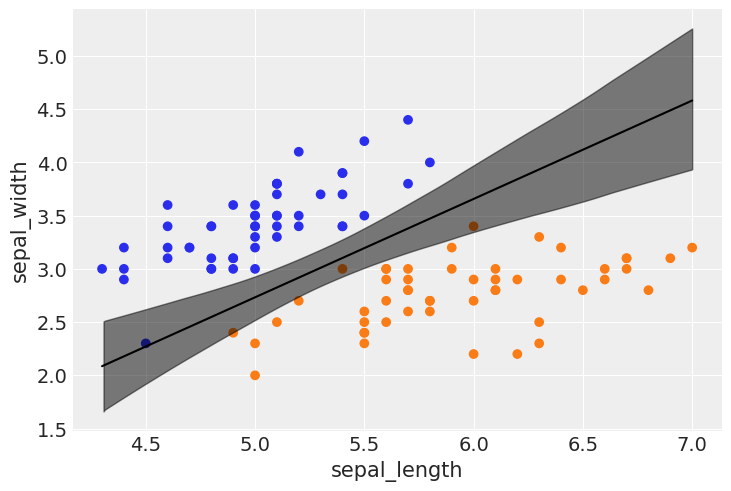

In [59]:
idx = np.argsort(x_1[:,0]) 


bd_mean = trace_1.posterior['bd'].mean(axis=0).mean(axis=0)


plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 

bd = bd_mean[idx]

plt.plot(x_1[:,0][idx], bd, color='k'); 


az.plot_hdi(x_1[:,0], trace_1.posterior['bd'], color='k')
 
    
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])



## Prediction on unseen data

In [102]:
print(np.shape(x_1), type(x_1))

udata = np.array(((5.2,2.0),(7.0,2.0),(4.5,5.0),(5.5,3.2)))

print(np.shape(udata), type(udata))


#dic = {'x_1': udata[:,0].tolist(), 'sepal_width': udata[:,1].tolist()}
tmp_dic = {'x': udata}
#a=udata[:,0].tolist()
#print(type(a))
#print(a)

(100, 2) <class 'numpy.ndarray'>
(4, 2) <class 'numpy.ndarray'>


In [103]:
with model_1:
  pm.set_data(tmp_dic)
  y_test = pm.sample_posterior_predictive(trace_1, 200, model_1)


/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1709: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [104]:
print(np.shape(y_test['yl']), type(y_test['yl']))
res = y_test['yl'].mean(axis=0)
#res = np.round(y_test['yl'].mean(axis=0), decimals=0).astype(int)


for i,k in enumerate(udata):
  print('sepal_length, sepal_width, category: {:}, {:}'.format(udata[i], res[i]))

(200, 4) <class 'numpy.ndarray'>
sepal_length, sepal_width, category: [5.2 2. ], 0.99
sepal_length, sepal_width, category: [7. 2.], 1.0
sepal_length, sepal_width, category: [4.5 5. ], 0.0
sepal_length, sepal_width, category: [5.5 3.2], 0.425


## Question in class (from D. Zhu): why is the decision boundary linear?

In [ ]:
with pm.Model() as model_2: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
    𝛾 = pm.Normal('𝛾', mu=0, sd=2) 
     
    μ = α + pm.math.dot(x_1, β) + pm.math.dot(x_1[:,0]**2, 𝛾)
    
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0] - 𝛾/β[1] * x_1[:,0]**2)
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_2 = pm.sample(2000, tune=4000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝛾, β, α]


/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 26 seconds.


Text(0, 0.5, 'sepal_width')

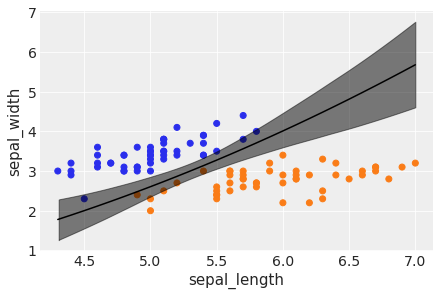

In [ ]:
idx = np.argsort(x_1[:,0]) 


bd_mean = trace_2.posterior['bd'].mean(axis=0).mean(axis=0)


plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 

bd = bd_mean[idx]

plt.plot(x_1[:,0][idx], bd, color='k'); 


az.plot_hdi(x_1[:,0], trace_2.posterior['bd'], color='k')
 
    
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])


In [ ]:
y_pred_2 = pm.sample_posterior_predictive(trace_2, 200, model_2) 

/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


## How to plot a variate distributed according to a PyMC model 

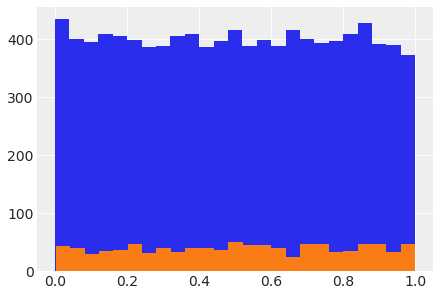

In [ ]:
with pm.Model() as model_testv:
    testv = pm.Beta('testv',1.,1.)
    


syn1 = testv.random(size=10000)
plt.hist(syn1, bins=25);

syn2 = testv.random(size=1000)
plt.hist(syn2, bins=25);

